# RNN

       Date Daily minimum temperatures
0  1/1/1981                       20.7
1  1/2/1981                       17.9
2  1/3/1981                       18.8
3  1/4/1981                       14.6
4  1/5/1981                       15.8
Index(['Date', 'Daily minimum temperatures'], dtype='object')


2025-12-04 07:33:35.578502: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 64)             │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,289 (16.75 KB)

 Trainable params: 4,289 (16.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0603 - val_loss: 0.0123
Epoch 2/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0132 - val_loss: 0.0103
Epoch 3/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0111 - val_loss: 0.0096
Epoch 4/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0105 - val_loss: 0.0092
Epoch 5/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0095 - val_loss: 0.0111
Epoch 6/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0099 - val_loss: 0.0094
Epoch 7/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0086 - val_loss: 0.0093
Epoch 8/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0092 - val_loss: 0.0093
Epoch 9/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0097 - val_loss: 0.0097
Epoch 10/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0090 - val_loss: 0.0093
Epoch 11/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0090 - val_loss: 0.0092
Epoch 12/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0090 - val_lo

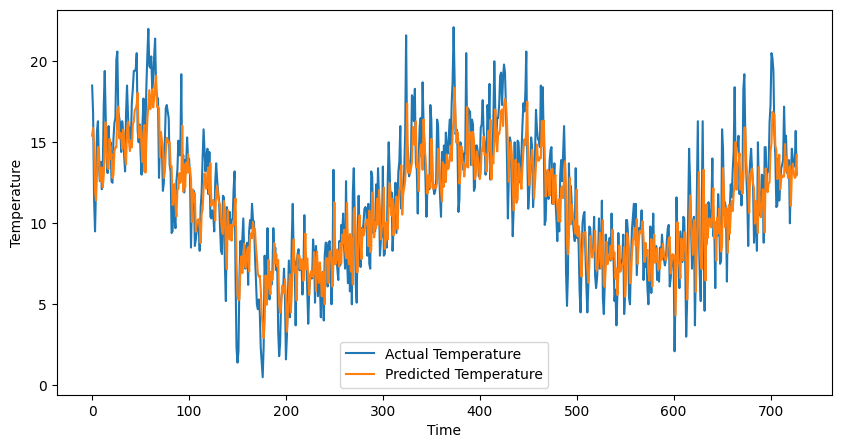

In [5]:
# 1. Import Libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
import matplotlib.pyplot as plt

# 2. Load Dataset
df = pd.read_csv("/kaggle/input/dataset/daily-minimum-temperatures-in-me.csv")
print(df.head())
print(df.columns)

# Identify the temperature column (2nd column)
temp_col = df.columns[1]

# 2A. Clean the temperature column (important)
df[temp_col] = (
    df[temp_col]
    .astype(str)
    .str.replace("?", "", regex=False)   # remove ?
    .str.replace(" ", "", regex=False)   # remove spaces
)

df[temp_col] = pd.to_numeric(df[temp_col], errors='coerce')
df = df.dropna(subset=[temp_col])  # remove corrupted rows

# Extract temperature values
data = df[temp_col].values.reshape(-1, 1)

# 3. Feature Scaling
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# 4. Convert Time Series to Supervised Data
def create_dataset(dataset, time_step=1):
    X, y = [], []
    for i in range(len(dataset) - time_step):
        X.append(dataset[i:(i+time_step), 0])
        y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 10
X, y = create_dataset(data_scaled, time_step)

# 4A. Reshape input to [samples, time_steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)

# 5. Split into Train and Test
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 6. Build RNN Model
model = Sequential()
model.add(SimpleRNN(64, activation='tanh', input_shape=(time_step, 1)))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')
model.summary()

# 7. Train Model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1
)

# 8. Prediction
y_pred = model.predict(X_test)

# 9. Convert predictions back to original scale
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# 10. Plot Results
plt.figure(figsize=(10,5))
plt.plot(y_test_inv, label='Actual Temperature')
plt.plot(y_pred_inv, label='Predicted Temperature')
plt.xlabel("Time")
plt.ylabel("Temperature")
plt.legend()
plt.show()


# CNN

2025-12-11 16:32:46.312467: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765470766.559519      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765470766.647557      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Training data shape: (50000, 32, 32, 3)
Test data shape: (10000, 32, 32, 3)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-12-11 16:33:10.903622: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 356,810 (1.36 MB)

 Trainable params: 356,810 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 52s 40ms/step - accuracy: 0.3176 - loss: 1.8311 - val_accuracy: 0.5584 - val_loss: 1.2560
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 48s 38ms/step - accuracy: 0.5642 - loss: 1.2248 - val_accuracy: 0.6298 - val_loss: 1.0409
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 48s 38ms/step - accuracy: 0.6431 - loss: 1.0269 - val_accuracy: 0.6607 - val_loss: 0.9575
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 48s 38ms/step - accuracy: 0.6842 - loss: 0.9032 - val_accuracy: 0.7115 - val_loss: 0.8305
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 49s 39ms/step - accuracy: 0.7166 - loss: 0.8115 - val_accuracy: 0.7322 - val_loss: 0.7838
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 48s 38ms/step - accuracy: 0.7430 - loss: 0.7372 - val_accuracy: 0.7195 - val_loss: 0.8158
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 48s 38ms/step - accuracy: 0.7648 - loss: 0.6694 - val_accuracy: 0.7338 - val_loss: 0.7713
Epoch 8/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 81s 38ms/step - accuracy: 0.7855 -

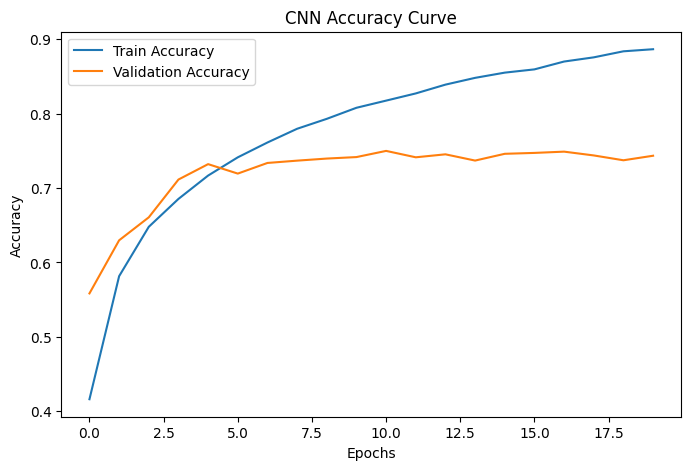

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
Predicted Class: 0


In [1]:
# 1. Import Libraries
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# 2. Load CIFAR-10 Dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

# 3. Normalize Images (0–255 -> 0–1)
X_train = X_train.astype("float32") / 255.0
X_test = X_test.astype("float32") / 255.0

# 4. One-hot encode labels
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# 5. Build CNN Model
model = Sequential()

# Block 1
model.add(Conv2D(32, (3,3), activation='relu', padding="same", input_shape=(32,32,3)))
model.add(MaxPooling2D((2,2)))

# Block 2
model.add(Conv2D(64, (3,3), activation='relu', padding="same"))
model.add(MaxPooling2D((2,2)))

# Block 3
model.add(Conv2D(128, (3,3), activation='relu', padding="same"))
model.add(MaxPooling2D((2,2)))

# Flatten
model.add(Flatten())

# Dense Layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(10, activation='softmax'))  # 10 classes

# 6. Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# 7. Train the model
history = model.fit(
    X_train,
    y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2
)

# 8. Evaluate on test data
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_acc)

# 9. Plot Accuracy Curve
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("CNN Accuracy Curve")
plt.legend()
plt.show()

# 10. Predict a single image
import numpy as np

index = 5  # choose any image
sample = X_test[index].reshape(1,32,32,3)
prediction = model.predict(sample)

print("Predicted Class:", prediction.argmax())
